In [5]:
import numpy as np
import pandas as pd
import easydatascience as eds

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import waterfall_chart

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
import joblib

plt.rcParams.update({'figure.figsize':(8, 5), 'figure.dpi':100})

data = pd.read_csv('data.csv')

X_train, X_test, y_train, y_test = train_test_split(data.drop('Blue_Won', axis=1), 
                                                    data['Blue_Won'], test_size=0.1)

## EDA

### Baseline

In [6]:
def kfold_test(df, y, model, iters=1, kfolds=10):
    # K-fold CV over n iterations. Returns a list of lists
    # containing average accuracies and their stds
    kf = KFold(kfolds, shuffle=True)
    out = []

    for iter in range(iters):
        accuracies = []
        # k1 = k-1
        for k1_fold, k_fold in kf.split(df):
            model.fit(df.iloc[k1_fold], y.iloc[k1_fold])
        
            accuracies.append(accuracy_score(y.iloc[k_fold],
                              model.predict(df.iloc[k_fold])))
            
        out.append([np.mean(accuracies).round(3), np.std(accuracies).round(3)])
    
    return out

In [7]:
og_train, og_test = X_train.iloc[:, 1:15], X_test.iloc[:, 1:15]

og_train

,Blue_KillsTower,Blue_KillsInhib,Blue_KillsBaron,Blue_KillsDragon,Purp_KillsTower,Purp_KillsInhib,Purp_KillsBaron,Purp_KillsDragon,Blue_Kills,Blue_Assists,Blue_Gold,Purp_Kills,Purp_Assists,Purp_Gold
16148,1,0,0,1,8,1,0,3,15.0,19.0,40082.0,35.0,49.0,52693.0
25262,9,2,1,3,5,0,0,2,49.0,56.0,68315.0,37.0,34.0,62623.0
19806,3,0,0,1,7,1,0,4,17.0,19.0,59904.0,33.0,45.0,64937.0
16324,11,5,2,3,2,0,0,1,35.0,40.0,64199.0,34.0,51.0,59829.0
11855,1,0,0,0,9,1,1,4,20.0,22.0,42680.0,32.0,35.0,54119.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3722,5,1,0,1,11,4,1,4,33.0,61.0,67872.0,47.0,72.0,76494.0
8427,8,1,1,2,3,0,0,3,29.0,52.0,61226.0,29.0,52.0,58518.0
20921,2,0,0,0,10,2,0,4,14.0,19.0,39491.0,35.0,48.0,53328.0
5316,8,1,1,4,2,0,0,0,29.0,66.0,52223.0,8.0,17.0,35818.0


In [8]:
og_train, og_test = X_train.iloc[:, 1:15], X_test.iloc[:, 1:15]

xgbc = XGBClassifier()

og_scores = kfold_test(og_train, y_train, xgbc, iters=3, kfolds=5)

print('Accuracies of a simple model:\n')
for i, v in enumerate(og_scores):
    print('Iteration '+str(i+1)+':\nMean: '+str(v[0])+' Std: '+str(v[1])+'\n')

Accuracies of a simple model:

Iteration 1:
Mean: 0.985 Std: 0.001

Iteration 2:
Mean: 0.986 Std: 0.001

Iteration 3:
Mean: 0.986 Std: 0.001



In [9]:
# Fitting the model, printing feature importances and then removing
# the most influential feature. The process is repeated.

def minus_one(df, y, model, iters):
    curr_data = df.copy()

    for _ in range(iters):
        model.fit(curr_data, y);

        for ftr, imprt in zip(curr_data.columns, model.feature_importances_):
            print(ftr, imprt.round(3))
        
        # Drop the most influential feature
        curr_data = curr_data.drop(curr_data.columns[model.feature_importances_.argmax()], axis=1)
        print(21*'-')
    
minus_one(og_train, y_train, XGBClassifier(), og_train.shape[1]-1)

Blue_KillsTower 0.069
Blue_KillsInhib 0.045
Blue_KillsBaron 0.006
Blue_KillsDragon 0.004
Purp_KillsTower 0.061
Purp_KillsInhib 0.768
Purp_KillsBaron 0.01
Purp_KillsDragon 0.007
Blue_Kills 0.003
Blue_Assists 0.008
Blue_Gold 0.004
Purp_Kills 0.004
Purp_Assists 0.007
Purp_Gold 0.004
---------------------
Blue_KillsTower 0.082
Blue_KillsInhib 0.746
Blue_KillsBaron 0.008
Blue_KillsDragon 0.005
Purp_KillsTower 0.101
Purp_KillsBaron 0.007
Purp_KillsDragon 0.012
Blue_Kills 0.004
Blue_Assists 0.01
Blue_Gold 0.005
Purp_Kills 0.004
Purp_Assists 0.01
Purp_Gold 0.005
---------------------
Blue_KillsTower 0.2
Blue_KillsBaron 0.015
Blue_KillsDragon 0.011
Purp_KillsTower 0.662
Purp_KillsBaron 0.02
Purp_KillsDragon 0.012
Blue_Kills 0.009
Blue_Assists 0.02
Blue_Gold 0.009
Purp_Kills 0.01
Purp_Assists 0.022
Purp_Gold 0.01
---------------------
Blue_KillsTower 0.777
Blue_KillsBaron 0.013
Blue_KillsDragon 0.016
Purp_KillsBaron 0.033
Purp_KillsDragon 0.008
Blue_Kills 0.014
Blue_Assists 0.02
Blue_Gold 0.023


### Prediction influencers and the "Dragons" features

In [10]:
dragon_X, dragon_y = og_train.drop(['Blue_KillsDragon', 'Purp_KillsDragon'], axis=1), og_train['Blue_KillsDragon']

xgbr = XGBRegressor()

xgbr.fit(dragon_X, dragon_y)
minus_one(dragon_X, dragon_y, XGBRegressor(), 5)

Blue_KillsTower 0.581
Blue_KillsInhib 0.029
Blue_KillsBaron 0.017
Purp_KillsTower 0.057
Purp_KillsInhib 0.03
Purp_KillsBaron 0.025
Blue_Kills 0.039
Blue_Assists 0.027
Blue_Gold 0.076
Purp_Kills 0.059
Purp_Assists 0.028
Purp_Gold 0.033
---------------------
Blue_KillsInhib 0.702
Blue_KillsBaron 0.012
Purp_KillsTower 0.049
Purp_KillsInhib 0.028
Purp_KillsBaron 0.016
Blue_Kills 0.025
Blue_Assists 0.017
Blue_Gold 0.062
Purp_Kills 0.042
Purp_Assists 0.02
Purp_Gold 0.026
---------------------
Blue_KillsBaron 0.016
Purp_KillsTower 0.477
Purp_KillsInhib 0.029
Purp_KillsBaron 0.026
Blue_Kills 0.067
Blue_Assists 0.029
Blue_Gold 0.188
Purp_Kills 0.093
Purp_Assists 0.035
Purp_Gold 0.041
---------------------
Blue_KillsBaron 0.012
Purp_KillsInhib 0.505
Purp_KillsBaron 0.021
Blue_Kills 0.124
Blue_Assists 0.023
Blue_Gold 0.15
Purp_Kills 0.098
Purp_Assists 0.028
Purp_Gold 0.039
---------------------
Blue_KillsBaron 0.022
Purp_KillsBaron 0.029
Blue_Kills 0.181
Blue_Assists 0.038
Blue_Gold 0.314
Purp_Ki

Predicting the # of dragons tests:

RMSE: 0.994

Confusion matrix of the rounded predictions:


,0 Drakes,1 Drakes,2 Drakes,3 Drakes,4 Drakes,5 Drakes
0 Drakes,28,235,54,12,1,0
1 Drakes,27,304,146,98,2,0
2 Drakes,4,180,232,260,16,0
3 Drakes,0,65,162,359,37,0
4 Drakes,0,5,73,345,68,1
5 Drakes,0,0,4,34,24,0


Text(0, 0.5, 'Predicted values')

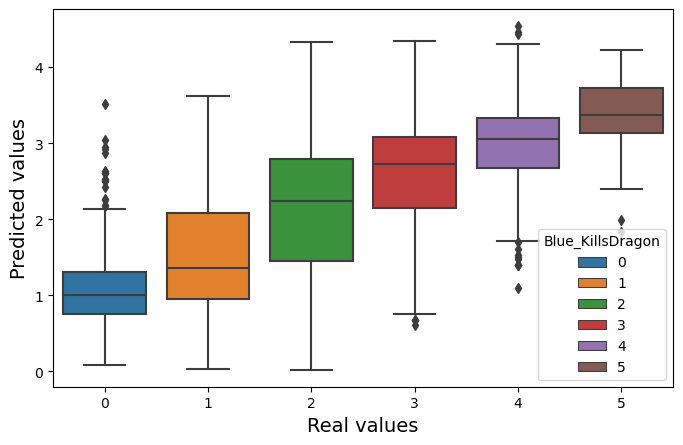

In [11]:
dragon_X_test, dragon_y_test = og_test.drop(['Blue_KillsDragon', 'Purp_KillsDragon'], axis=1), og_test['Blue_KillsDragon']
preds = xgbr.predict(dragon_X_test)

rmse = np.sqrt(mean_squared_error(dragon_y_test, preds))
print('Predicting the # of dragons tests:\n\nRMSE:', round(rmse, 3))

# Rounding the predictions and making a confusion matrix
col_names = [str(i) + ' Drakes' for i in range(6)]
print('\nConfusion matrix of the rounded predictions:')
display(pd.DataFrame(confusion_matrix(dragon_y_test, np.round(preds)), index=col_names, columns=col_names))

print('\n\n')

fig, ax = plt.subplots()
sns.boxplot(x=dragon_y_test, y=preds, hue=dragon_y_test, dodge=False)
ax.set_xlabel('Real values', fontsize=14)
ax.set_ylabel('Predicted values', fontsize=14)

### More simple model evaluation

In [25]:
# Logistic regression for influencers
# Bad model because of the between feature colinearity but interpretable
scaler = StandardScaler()

scaler.fit(og_train)
og_scaled_train, og_scaled_test = scaler.transform(og_train), scaler.transform(og_test)

cv_lr = kfold_test(pd.DataFrame(og_train), y_train, LogisticRegression(max_iter=1000))[0]
cv_scaled_lr = kfold_test(pd.DataFrame(og_scaled_train), y_train, LogisticRegression())[0]

print('Means and standard deviations of single 10-fold cv-s:\nUnscaled:', cv_lr, '\nScaled:', cv_scaled_lr)

Means and standard deviations of single 10-fold cv-s:
Unscaled: [0.984, 0.004] 
Scaled: [0.986, 0.002]


<strong>&emsp;Note: The Logistic Regression model does not converge at all at default "max_iter = 100" (ConvergenceWarining) if the data isn't scaled.<strong>

In [26]:
coefs = pd.concat([pd.Series(i) for i in [xgbc.feature_importances_, LogisticRegression().fit(og_scaled_train, y_train).coef_[0],
                                          og_train.corrwith(y_train).values]], axis=1)
coefs.columns, coefs.index = ['XGBC Ft.Imp.', 'Log.Reg.Coef.', 'Target corr.'], og_train.columns
coefs = coefs.round(3)
coefs

,XGBC Ft.Imp.,Log.Reg.Coef.,Target corr.
Blue_KillsTower,0.080,1.309,0.813
Blue_KillsInhib,0.065,0.742,0.699
Blue_KillsBaron,0.007,-0.136,0.504
Blue_KillsDragon,0.004,0.517,0.576
Purp_KillsTower,0.114,-1.431,-0.819
Purp_KillsInhib,0.671,-0.628,-0.702
Purp_KillsBaron,0.010,0.187,-0.529
Purp_KillsDragon,0.010,0.202,-0.586
Blue_Kills,0.003,-1.080,0.575
Blue_Assists,0.011,1.414,0.528


&emsp;<u>Columns of interest:</u><br>
 - <b>Purp_KillsInhib</b> - It seems that XGBoost does a poor job of generalizing, and in this sample (the feature with the greatest feature importance will probably change as I rerun the cells multiple times) it is that Putp_KillsInhib that is heavility weighted. This could be adressed with model tuning but XGBoost with default hyperparameters doesn't seem like the best option right now.
 - <b>Blue_KillsBaron</b> and <b>Purp_KillsBaron</b> - The multicollinearity is taking its toll here. It messes up the features so even though the correlation is positive, the weight is negative because these features are influenced by other features.
 - <b>Blue_Kills</b> and <b>Purp_Kills</b> - Same story as with the baron features.

### Diff features

In [27]:
blue = pd.concat([og_train.iloc[:, :4], og_train.iloc[:, 8:11]], axis=1)
purp = pd.concat([og_train.iloc[:, 4:8], og_train.iloc[:, 11:14]], axis=1)

for df in [blue, purp]:
    df.columns = ['Diff_Kills'+i for i in ['Tower', 'Inhib', 'Baron', 'Dragon', '']] + ['Diff_'+i for i in ['Assists', 'Gold']]
    
diff_data = blue - purp
xgbc.fit(diff_data, y_train)

diff_scores = kfold_test(diff_data, y_train, xgbc, iters=3, kfolds=5)
print('Accuracies of the diff model:\n')
for i, v in enumerate(diff_scores):
    print('Iteration '+str(i+1)+':\nMean: '+str(v[0])+' Std: '+str(v[1])+'\n')

Accuracies of the diff model:

Iteration 1:
Mean: 0.985 Std: 0.002

Iteration 2:
Mean: 0.985 Std: 0.002

Iteration 3:
Mean: 0.984 Std: 0.001



In [28]:
# Test diff data
blue = pd.concat([og_test.iloc[:, :4], og_test.iloc[:, 8:11]], axis=1)
purp = pd.concat([og_test.iloc[:, 4:8], og_test.iloc[:, 11:14]], axis=1)

for df in [blue, purp]:
    df.columns = ['Diff_Kills'+i for i in ['Tower', 'Inhib', 'Baron', 'Dragon', '']] + ['Diff_'+i for i in ['Assists', 'Gold']]

diff_test = blue - purp

In [29]:
print('Between-feature correnaltions in the difference data:')
eds.print_abv_ft_corr(diff_data)

Between-feature correnaltions in the difference data:

---------------------
 Diff_KillsTower:
---------------------

Diff_KillsInhib 0.9059
Diff_KillsBaron 0.5877
Diff_KillsDragon 0.6319
Diff_Kills 0.8183
Diff_Assists 0.644
Diff_Gold 0.918

---------------------
 Diff_KillsInhib:
---------------------

Diff_KillsTower 0.9059
Diff_KillsBaron 0.568
Diff_KillsDragon 0.5665
Diff_Kills 0.7224
Diff_Assists 0.5833
Diff_Gold 0.8031

---------------------
 Diff_KillsBaron:
---------------------

Diff_KillsTower 0.5877
Diff_KillsInhib 0.568
Diff_KillsDragon 0.3986
Diff_Kills 0.5364
Diff_Assists 0.4913
Diff_Gold 0.661

---------------------
 Diff_KillsDragon:
---------------------

Diff_KillsTower 0.6319
Diff_KillsInhib 0.5665
Diff_KillsBaron 0.3986
Diff_Kills 0.6323
Diff_Assists 0.4881
Diff_Gold 0.6523

---------------------
 Diff_Kills:
---------------------

Diff_KillsTower 0.8183
Diff_KillsInhib 0.7224
Diff_KillsBaron 0.5364
Diff_KillsDragon 0.6323
Diff_Assists 0.8457
Diff_Gold 0.9164

-----

In [30]:
coefs = pd.concat([pd.Series(i) for i in [xgbc.feature_importances_, LogisticRegression().fit(StandardScaler().fit_transform(diff_data), y_train).coef_[0],
                                          diff_data.corrwith(y_train).values]], axis=1)
coefs.columns, coefs.index = ['XGBC Ft.Imp.', 'Log.Reg.Coef.', 'Target corr.'], diff_data.columns
coefs = coefs.round(3)

print('Features in the difference data:')
display(coefs)

Features in the difference data:


,XGBC Ft.Imp.,Log.Reg.Coef.,Target corr.
Diff_KillsTower,0.048,2.427,0.873
Diff_KillsInhib,0.080,1.248,0.804
Diff_KillsBaron,0.016,-0.315,0.618
Diff_KillsDragon,0.013,0.295,0.615
Diff_Kills,0.016,-1.691,0.825
Diff_Assists,0.022,2.140,0.748
Diff_Gold,0.804,6.041,0.898


### Diff Gold feature prediction

In [31]:
y_diff_gold = diff_data['Diff_Gold']
X_diff_gold = diff_data.drop('Diff_Gold', axis=1)

y_diff_gold_test = diff_test['Diff_Gold']
X_diff_gold_test = diff_test.drop('Diff_Gold', axis=1)

scaler.fit(X_diff_gold)

# Normalized "y"
#from sklearn.preprocessing import PowerTransformer

#pt = PowerTransformer()

# Linear Regression
lr_gold = LinearRegression()
lr_gold.fit(scaler.transform(X_diff_gold), y_diff_gold)

preds = lr_gold.predict(scaler.transform(X_diff_gold_test))

print('RMSE of the Gold_Diff in the test set:', np.sqrt(mean_squared_error(y_diff_gold_test, preds)))

# XGB Regressor
xgb_gold = XGBRegressor()

xgb_gold.fit(X_diff_gold, y_diff_gold)

xgb_preds = xgb_gold.predict(X_diff_gold_test)
print('RMSE of the Gold_Diff in the test set:', np.sqrt(mean_squared_error(y_diff_gold_test, xgb_preds)))

RMSE of the Gold_Diff in the test set: 2242.817754097532
RMSE of the Gold_Diff in the test set: 2278.591629727575


Distribution of the Gold Difference in the predictions:


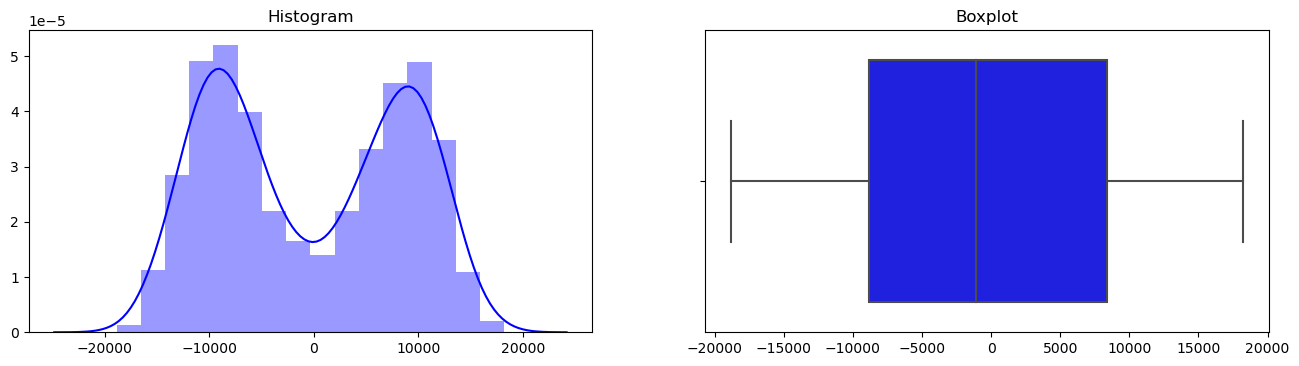


Skew:  0.0432
Mean:  -341.8373
Standard Deviation:  9155.5788


Distribution of the Gold Difference in the train set:


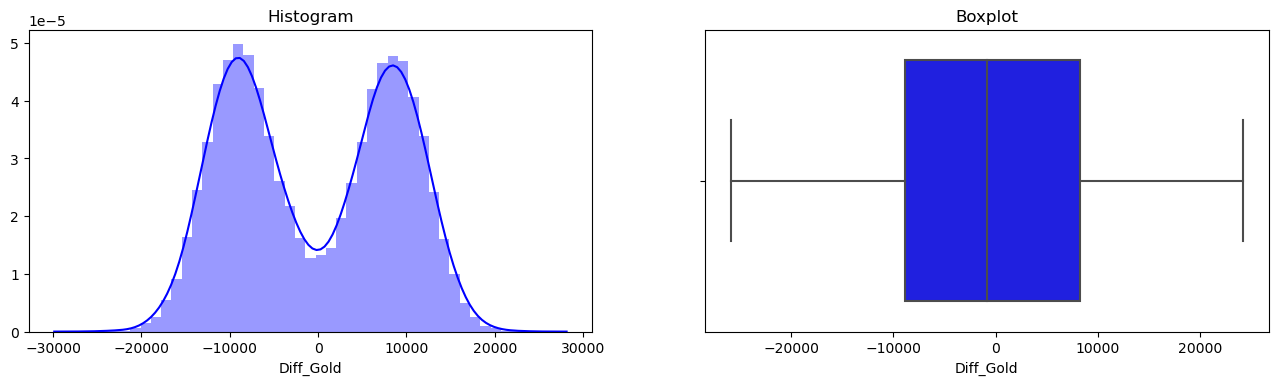


Skew:  0.0149
Mean:  -365.7984
Standard Deviation:  9395.8445


In [32]:
print('Distribution of the Gold Difference in the predictions:')
eds.plot_spread(pd.Series(preds.flatten()))

print('\n\nDistribution of the Gold Difference in the train set:')
eds.plot_spread(y_diff_gold)

In [33]:
print('Sample Predictions:')
pd.concat([X_diff_gold_test, pd.Series(preds, index=X_diff_gold_test.index)], axis=1).rename(columns={0: 'Pred_Diff_Gold'}).sample(5)

Sample Predictions:


,Diff_KillsTower,Diff_KillsInhib,Diff_KillsBaron,Diff_KillsDragon,Diff_Kills,Diff_Assists,Pred_Diff_Gold
2270,1,0,1,0,7.0,24.0,4473.049956
15549,7,2,1,2,11.0,22.0,9475.945381
20512,0,0,0,-3,-13.0,-59.0,-5185.677413
21489,-8,-2,-1,-3,-26.0,-20.0,-14931.192121
23054,-5,-1,-2,2,-7.0,-21.0,-8619.522012


How prediction varies based on each feature

Feature vecotr used in the plot:


,Diff_KillsTower,Diff_KillsInhib,Diff_KillsBaron,Diff_KillsDragon,Diff_Kills,Diff_Assists
2237,-7,-1,0,1,-6.0,-11.0


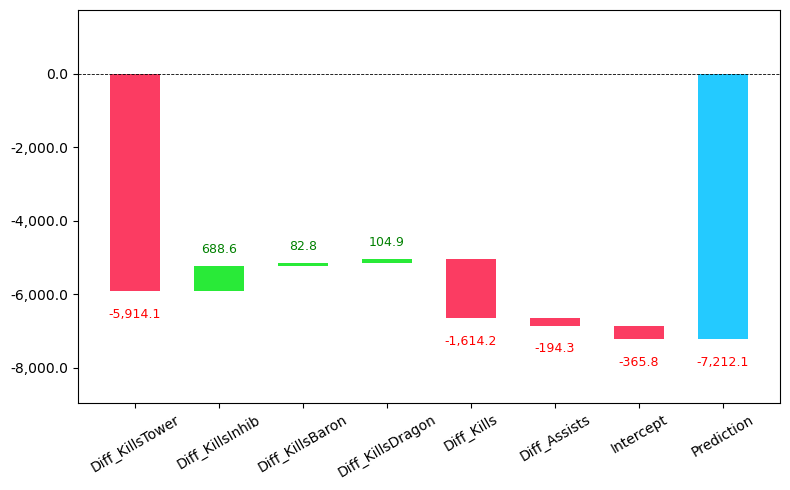

In [34]:
# Plotting Linear Regression influencers
values = (scaler.transform(X_diff_gold_test.iloc[:1]) * lr_gold.coef_).tolist()[0] + [lr_gold.intercept_]

print('How prediction varies based on each feature\n\nFeature vector used in the plot:')
display(X_diff_gold_test.iloc[:1])

waterfall_chart.plot(X_diff_gold.columns.tolist()+['Intercept'], values, net_label='Prediction');

In [35]:
gold_coefs = pd.concat([pd.Series(i) for i in [xgb_gold.feature_importances_, lr_gold.coef_,
                                          X_diff_gold.corrwith(y_diff_gold).values]], axis=1)
gold_coefs.columns, gold_coefs.index = ['XGBC Ft.Imp.', 'Lin.Reg.Coef.', 'Target corr.'], X_diff_gold.columns
gold_coefs = gold_coefs.round(3)

print('Features in the difference data:')
display(gold_coefs)

Features in the difference data:


,XGBC Ft.Imp.,Lin.Reg.Coef.,Target corr.
Diff_KillsTower,0.778,5419.117,0.918
Diff_KillsInhib,0.007,-1355.355,0.803
Diff_KillsBaron,0.037,1401.632,0.661
Diff_KillsDragon,0.004,250.763,0.652
Diff_Kills,0.170,3863.968,0.916
Diff_Assists,0.004,450.463,0.769


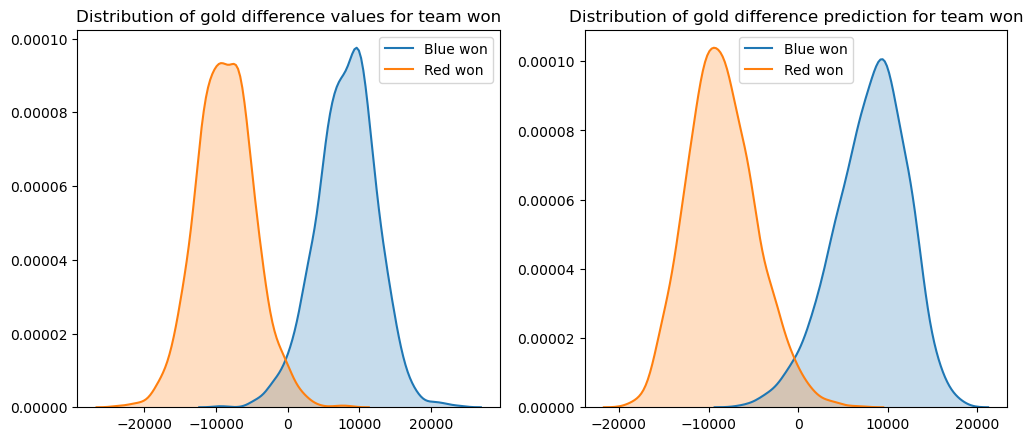

In [36]:
# Plotting gold spread by team won (real vs predicted)
# Real
plt_target_data = pd.concat([y_diff_gold_test, y_test], axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(plt_target_data.loc[plt_target_data['Blue_Won']==1]['Diff_Gold'], shade=True, ax=ax[0])
sns.kdeplot(plt_target_data.loc[plt_target_data['Blue_Won']==0]['Diff_Gold'], shade=True, ax=ax[0])

ax[0].legend(['Blue won', 'Red won'])
ax[0].set_title('Distribution of gold difference values for team won')

# Predicted
plt_pred_data =  pd.concat([pd.Series(preds, index=y_test.index), y_test], axis=1)

sns.kdeplot(plt_pred_data.loc[plt_pred_data['Blue_Won']==1][0], shade=True, ax=ax[1])
sns.kdeplot(plt_pred_data.loc[plt_pred_data['Blue_Won']==0][0], shade=True, ax=ax[1])

ax[1].legend(['Blue won', 'Red won'])
ax[1].set_title('Distribution of gold difference prediction for team won');

&emsp; Since Gold_Diff is the most useful feature (and the feature that contains the most information since a lot of other features influence it), it is wise to properly examine it. I took into acount simple Lin.Reg. and XGB Regressor, but since the vanilla XGB was there only for comparison and since it is not as __interpretable__, I decided to stick with the __Lin.Reg.__ for the most time.<br>
&emsp; __RMSE__ of 2300 gold is actually an excellent number since that means that error difference beteween each player is only 460, which is practically nothing, __1st and 3rd quartiles__ of ~7500 are also pretty good.<br>
&emsp;It seems that __between-the-features correlation__ is messing the things up again (will be adressed shortly), as observed before, some Lin.Reg. coefficients have completely opposite values. On the other side, the __proportion of coefficients__ seems okay at glance (except __Diff_KillsInhib__).

### Feature reduction by components - PCA/PLS

In [37]:
from sklearn.decomposition import PCA

diff_data_scaled = scaler.fit_transform(diff_data)

pca = PCA(n_components=4)
pca.fit(diff_data_scaled)

print('Explained variance ratio by the first 4 components:', sum(pca.explained_variance_ratio_).round(6))

pca_data = pca.transform(diff_data_scaled)

pca_lr = LogisticRegression()
pca_lr.fit(pca_data, y_train)

pca_test = pca.transform(scaler.transform(diff_test))

print('Test set accuracy:', round(accuracy_score(y_test, pca_lr.predict(pca_test)), 5))

Explained variance ratio by the first 4 components: 0.961145
Test set accuracy: 0.98451


In [38]:
pd.DataFrame(confusion_matrix(y_test, pca_lr.predict(pca_test)), index=['Real Blue Lost', 'Real Blue Won'],
             columns=['Pred Blue Lost', 'Pred Blue Won'])

,Pred Blue Lost,Pred Blue Won
Real Blue Lost,1388,20
Real Blue Won,23,1345


&emsp;Scikit-learn inverts the confusion matrix by default (inverted binary classes).

In [21]:
# Exporting pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('lr', LogisticRegression())])
pipeline.fit(diff_data, y_train)

with open('lr_pipeline.pkl', 'wb') as f:
    joblib.dump(pipeline, f)
    
joblib.dump(pipeline, 'lr_pipeline.pkl')

['lr_pipeline.pkl']

### Neural Net to combine the time feature with other features (late game feature importance)?
As the game progresses, the gold difference becomes less significat as every champion hits a power celling they can get from buying items (gold) since they only have 6 item slots and some champions are designed to be good in the late game. Those certain champions being on a certain team become the only winning factor the more the game goes on since all other factors are hitting their celling.

In [108]:
# Vladimir win rates after 30 minutes
dummie = X_train.loc[X_train['GameDuration']>1800]

for column, name in [['Blue_Top_ChampionID', 'Blue Top'], ['Purp_Top_ChampionID', 'Purp Top'],
                     ['Blue_Mid_ChampionID', 'Blue Mid'], ['Purp_Mid_ChampionID', 'Purp Mid']]:
    df = dummie.loc[dummie[column]==8]

    print(name + ' Win ratio:', round(y_train[df.index.tolist()].sum() / df.shape[0], 2))

Blue Top Win ratio: 0.47
Purp Top Win ratio: 0.46
Blue Mid Win ratio: 0.53
Purp Mid Win ratio: 0.44


#### Late game champions importance conclusion
Even though this might be a viable option to expand the feature space, it requires a lot more training samples (possibly close to a million) in order to have a reasonable amount of samples for every champion for every lane that champion can occupy. It would take approximately 1/3 of a year to obtain those samples with the current pace of scraping I am able to achieve so it doesn't sound like an optimal alocation of resources. Still, this is a thing to have in mind and that can be explored further.